Подключим библиотеки, которыми будем пользоваться

In [217]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer

Загрузим данные

In [218]:
data = pd.read_csv('train.csv')
## Выкидываем дубликатные кортежи
data = data.drop_duplicates()

Посмотрим на случайные кортежи с помощью функции .sample()

In [219]:
data.sample(10)

ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
2767            69           105.00    7297.75    Male                0   
1285            18            20.10     401.85    Male                0   
3950             8            29.35     216.45    Male                0   
4483            66            65.70     4378.9    Male                0   
586             20            44.35     927.15  Female                0   
5086             4            20.15      68.45  Female                0   
3366            67            75.70    5060.85    Male                1   
2828            64            65.80       4068  Female                0   
3389             3            40.15     130.75    Male                0   
3485             1            20.40       20.4    Male                0   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
2767        Yes      Yes             Yes                     Yes   
1285         No       No             Yes                      No   
3950         No       No              No        No phone service   
4483         No      Yes             Yes                     Yes   
586          No       No             Yes                      No   
5086         No       No             Yes                      No   
3366         No       No             Yes                     Yes   
2828        Yes      Yes             Yes                      No   
3389         No       No              No        No phone service   
3485        Yes      Yes             Yes                      No   

     HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
2767        Fiber optic                       No                  Yes   
1285                 No      No internet service  No internet service   
3950                DSL                      Yes                   No   
4483                DSL                      Yes                  Yes   
586                 DSL                       No                   No   
5086                 No      No internet service  No internet service   
3366        Fiber optic                       No                   No   
2828                DSL                      Yes                   No   
3389                DSL                       No                   No   
3485                 No      No internet service  No internet service   

      HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
2767                  Yes                   No                  Yes   
1285  No internet service  No internet service  No internet service   
3950                   No                   No                   No   
4483                   No                  Yes                   No   
586                    No                   No                   No   
5086  No internet service  No internet service  No internet service   
3366                   No                   No                   No   
2828                   No                  Yes                  Yes   
3389                  Yes                   No                  Yes   
3485  No internet service  No internet service  No internet service   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
2767                  Yes         Two year                Yes   
1285  No internet service         One year                 No   
3950                   No   Month-to-month                 No   
4483                   No         Two year                 No   
586                    No   Month-to-month                Yes   
5086  No internet service   Month-to-month                Yes   
3366                   No   Month-to-month                Yes   
2828                   No         One year                 No   
3389                   No   Month-to-month                Yes   
3485  No internet service         One year                 No   

                  PaymentMethod  Churn  
2767           Electronic check      0  
1285               Mailed check      0  
3950  

Посмотрим, есть ли в датасете незаполненные значения

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   object 
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

Как видим, незаполненных ячеек нет, но все же добавим один атрибут, который будет подсчитывать количество None ячеек в кортеже

In [221]:
def count_none_cells(row):
    return sum(1 for cell in row if cell is None)

data['NoneCells'] = data.apply(lambda row: count_none_cells(row), axis=1)

In [222]:

# Здесь я так делаю, так как есть 9 значений, которые нельзя преобразовать в число
# Я не уверен, что это лучшая практика, но без этого нельзя нормально построить гистограмму, так как нельзя выбрать
# range для оси Oy.
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
data['TotalSpent'] = data['TotalSpent'].fillna(0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

Как видим, все работает исправно.
Тогда перейдем ко второму пункту домашнего задания.

Теперь посторим гистограммы для атрибутов числового типа и диаграмму для категориального.

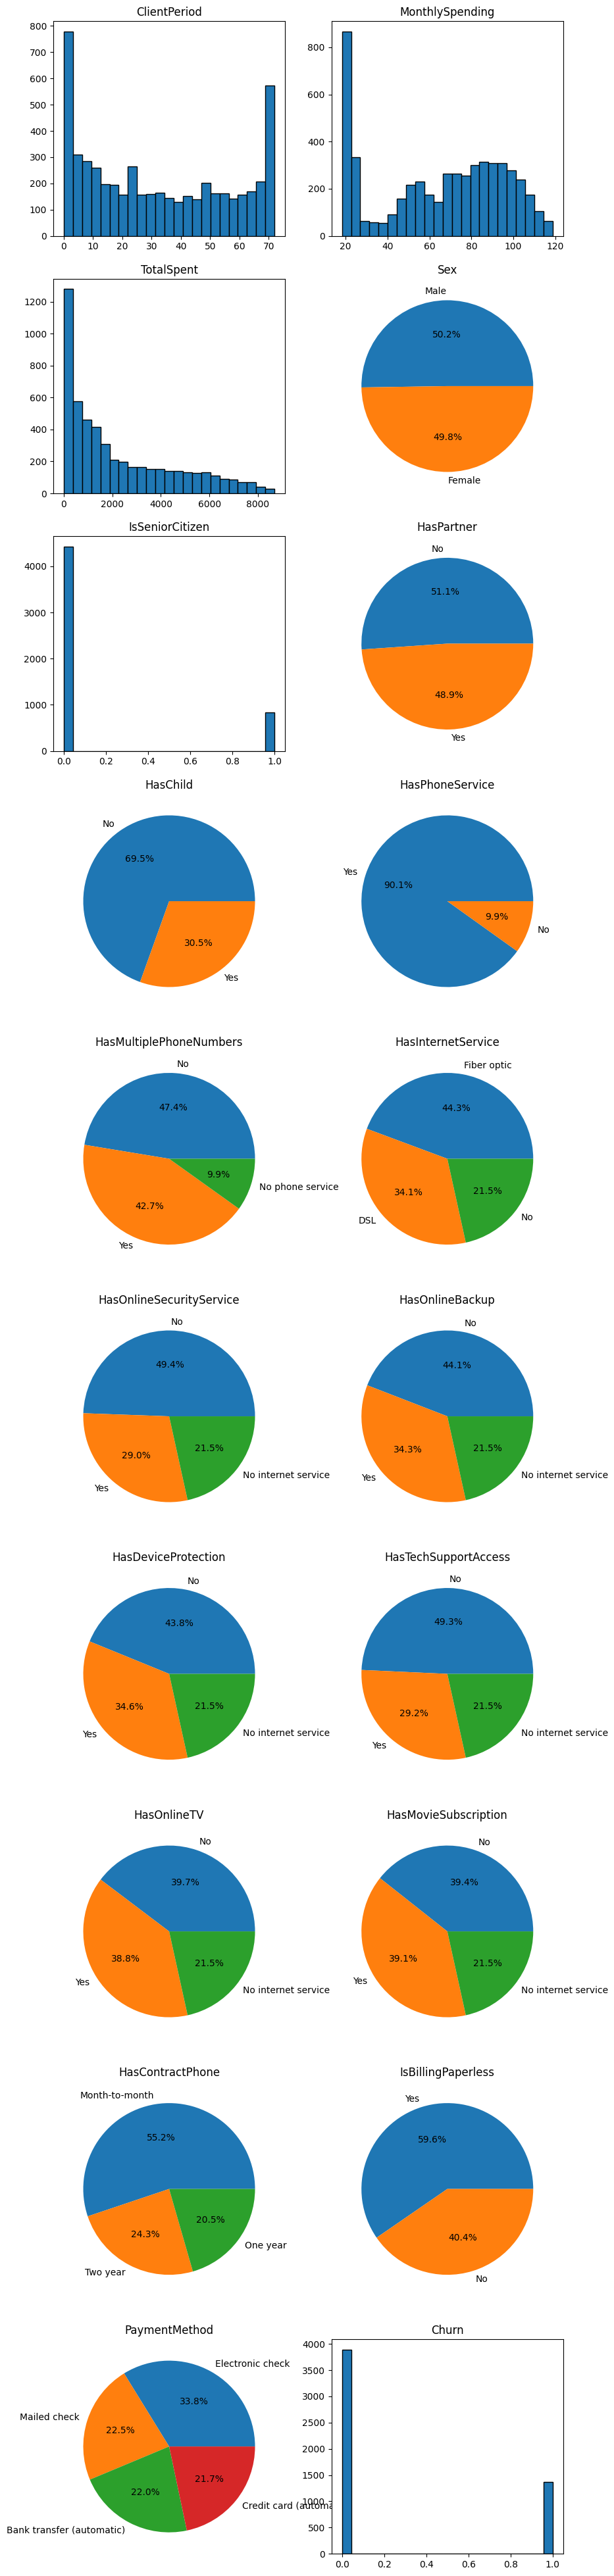

In [223]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(10, 50))
for ax, column in zip(axs.flatten(), data.columns):
    if pd.api.types.is_object_dtype(data[column]):
        ax.pie(data[column].value_counts(), labels=data[column].value_counts().index, autopct="%1.1f%%")
        ax.set_title(column)
    else:
        # Так как этот атрибут последний в нашем отношении
        if column == 'NoneCells':
            break
        else:
            ax.hist(data[column], bins=23, edgecolor='black')
            ax.set_title(column)

Теперь перейдем к третьему пункту работы.

In [224]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

X_train = data.drop('Churn', axis=1)
Y_train = data.Churn

scaler = StandardScaler()
logistic_regression = LogisticRegression()

category_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy="constant", fill_value="Null")),
                                        ('one_code_encoder', OneHotEncoder(drop='first', handle_unknown='error'))])
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy="constant", fill_value=np.nan)),
                                      ('standard_scaler', scaler)])

preprocessor = make_column_transformer(
    (numeric_transformer, make_column_selector(dtype_include=np.number)),
    (category_transformer, make_column_selector(dtype_include=object)))

# preprocessor = ColumnTransformer(transformers=[
#     ('category', category_transformer, cat_cols),
#     ('numeric', numeric_transformer, num_cols)
# ])

regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regression', logistic_regression)])

params = { 'regression__C': [100, 10, 1, 0.1, 0.01, 0.001], 
           'regression__penalty': ['l1', 'l2'],
           'regression__solver': ['liblinear']}

CV_regression = GridSearchCV(regression_pipeline, param_grid=params, scoring='roc_auc', error_score='raise')

CV_regression.fit(X_train, Y_train)

CV_regression.best_score_

0.8445701471163989

In [225]:
CV_regression.best_params_

{'regression__C': 100,
 'regression__penalty': 'l1',
 'regression__solver': 'liblinear'}

Третий пункт выполнен. Перейдем к последнему пункту.
Попробуем использовать catboost

In [227]:
from catboost import CatBoostClassifier

cat_params = {
    'depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.1],
    'n_estimators': [100, 200, 300],
    'cat_features': [cat_cols],
    'loss_function': ['Logloss', 'CrossEntropy']
}

CV_catboost = GridSearchCV(estimator=CatBoostClassifier(), param_grid=cat_params, scoring='roc_auc')

CV_catboost.fit(X_train, Y_train)
CV_catboost.best_score_

0:	learn: 0.6885463	total: 191ms	remaining: 18.9s
1:	learn: 0.6835616	total: 210ms	remaining: 10.3s
2:	learn: 0.6793582	total: 223ms	remaining: 7.22s
3:	learn: 0.6754605	total: 234ms	remaining: 5.63s
4:	learn: 0.6712023	total: 248ms	remaining: 4.7s
5:	learn: 0.6676964	total: 258ms	remaining: 4.03s
6:	learn: 0.6637955	total: 271ms	remaining: 3.6s
7:	learn: 0.6597221	total: 284ms	remaining: 3.26s
8:	learn: 0.6556331	total: 298ms	remaining: 3.01s
9:	learn: 0.6517229	total: 311ms	remaining: 2.8s
10:	learn: 0.6479190	total: 363ms	remaining: 2.94s
11:	learn: 0.6446638	total: 380ms	remaining: 2.79s
12:	learn: 0.6413686	total: 397ms	remaining: 2.65s
13:	learn: 0.6382318	total: 412ms	remaining: 2.53s
14:	learn: 0.6354618	total: 426ms	remaining: 2.41s
15:	learn: 0.6320937	total: 442ms	remaining: 2.32s
16:	learn: 0.6287363	total: 458ms	remaining: 2.23s
17:	learn: 0.6257039	total: 473ms	remaining: 2.15s
18:	learn: 0.6227428	total: 488ms	remaining: 2.08s
19:	learn: 0.6194645	total: 506ms	remaining:

0.8475874084701284

In [229]:
CV_catboost.best_params_

{'cat_features': ['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 'depth': 2,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'n_estimators': 100}

Обработаем тестовую выборку

In [247]:
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('submission.csv')

test_df.TotalSpent = test_df.TotalSpent.replace(' ', '0').astype('float')

Как видим, catboost лучше, поэтому применим его на тестовую выборку

In [248]:
Best_model = CatBoostClassifier(
    cat_features=cat_cols,
    depth=2,
    learning_rate=0.1,
    loss_function='Logloss',
    n_estimators=100
)

Best_model.fit(X_train, Y_train)

0:	learn: 0.6515643	total: 7.37ms	remaining: 730ms
1:	learn: 0.6177270	total: 14.6ms	remaining: 717ms
2:	learn: 0.5886934	total: 24.1ms	remaining: 778ms
3:	learn: 0.5665547	total: 36.4ms	remaining: 873ms
4:	learn: 0.5488303	total: 46ms	remaining: 874ms
5:	learn: 0.5351973	total: 54.7ms	remaining: 858ms
6:	learn: 0.5236366	total: 63.1ms	remaining: 839ms
7:	learn: 0.5112979	total: 71.2ms	remaining: 819ms
8:	learn: 0.5024168	total: 78.2ms	remaining: 791ms
9:	learn: 0.4884515	total: 86.1ms	remaining: 775ms
10:	learn: 0.4769854	total: 94.2ms	remaining: 762ms
11:	learn: 0.4681814	total: 102ms	remaining: 749ms
12:	learn: 0.4626600	total: 110ms	remaining: 735ms
13:	learn: 0.4559512	total: 118ms	remaining: 722ms
14:	learn: 0.4512313	total: 125ms	remaining: 707ms
15:	learn: 0.4471095	total: 133ms	remaining: 698ms
16:	learn: 0.4430100	total: 141ms	remaining: 689ms
17:	learn: 0.4398519	total: 150ms	remaining: 684ms
18:	learn: 0.4375309	total: 158ms	remaining: 674ms
19:	learn: 0.4354248	total: 166m

In [249]:
test_pred_prob = Best_model.predict_proba(test_df)
len(submission_df['Churn'])

1761

In [250]:
submission_df['Churn']=test_pred_prob[:, 1]

In [253]:
submission_df.to_csv('submission.csv', index=False)